In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from models.vanilla import VanillaModel
from utils.utils import create_data_loaders, freq_to_image
from ext.training import ReconstructionTrainer
from ext.plot import plot_fit

%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
args = {
    "seed" : 0,
    "data_path" : '/storage/downloads/fastmri_knee/',
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "batch_size" : 16,
    "num_workers" : 1,
    "num_epochs" : 10,
    "report_interval" : 1,
    "drop_rate" : .8,
    "learn_mask" : False,
    "results_root" : 'results',
    "lr" : 1e-2,
    "mask_lr" : 1e-2,
    "val_test_split" : .3,
}

args = Namespace(**args)

In [3]:

train_loader, validation_loader, test_loader = create_data_loaders(args) #get dataloaders

13898
2259
633
doggo  torch.Size([640, 368, 2])
doggo  torch.Size([640, 368, 2])
doggo  torch.Size([640, 368, 2])
doggo  torch.Size([640, 368, 2])
doggo  torch.Size([640, 368, 2])


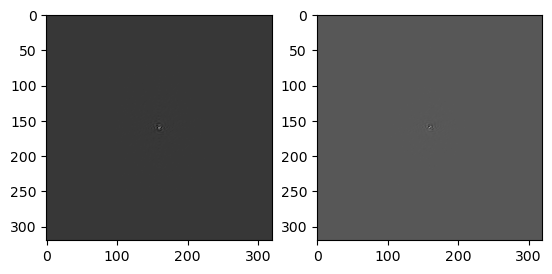

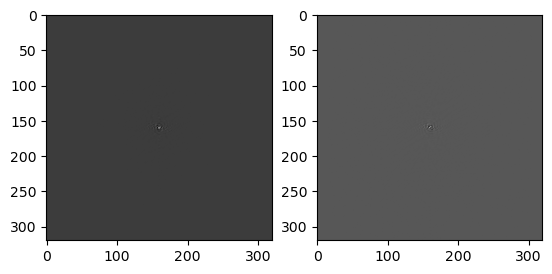

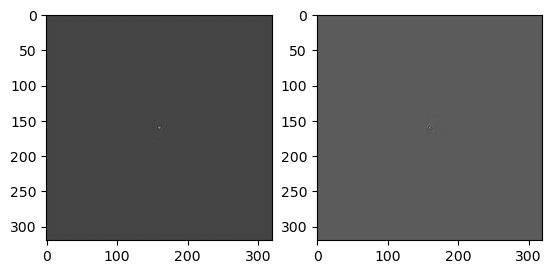

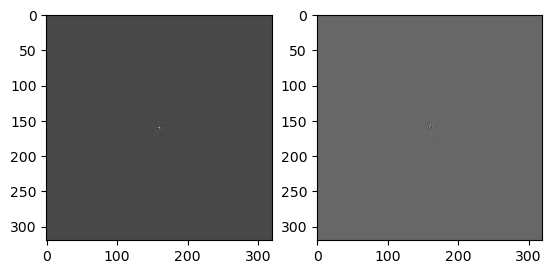

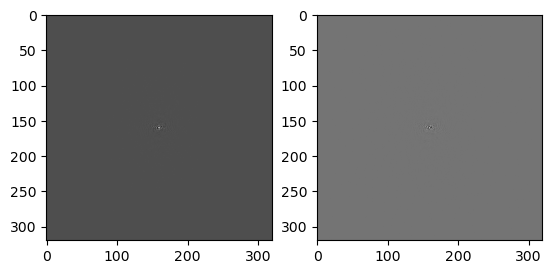

In [4]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))
print(len(validation_loader.dataset))
for i in range(5):
    x, y = train_loader.dataset[i]
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(x[:,:,0].numpy(), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(x[:,:,1].numpy(), cmap='gray')

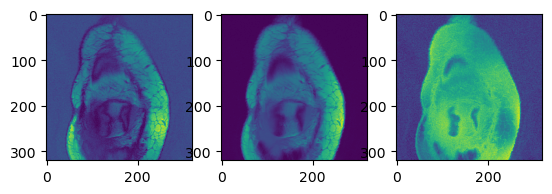

In [5]:
from utils.utils import freq_to_image
res = freq_to_image(x.unsqueeze(0))
plt.subplot(1, 3, 1)
plt.imshow(res[0])
plt.subplot(1, 3, 2)
plt.imshow(y)
plt.subplot(1, 3, 3)
plt.imshow(y - res[0])

In [6]:
def inverse_fft2_shift(kspace):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace, axes=(-2,-1)), norm='ortho'),axes=(-2,-1))

(40, 640, 368)
(40, 640, 368)


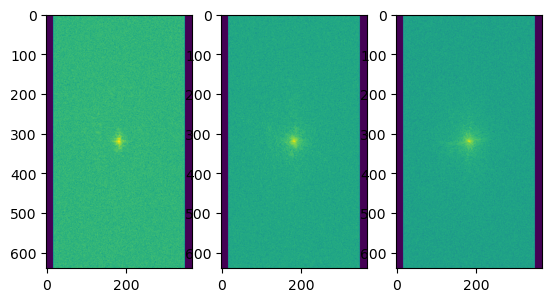

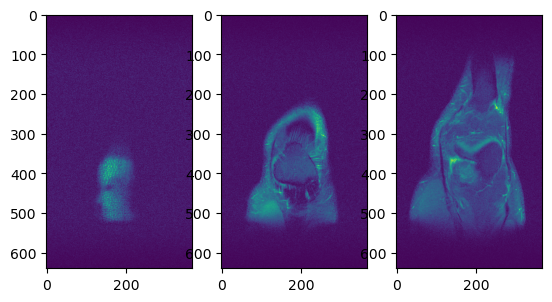

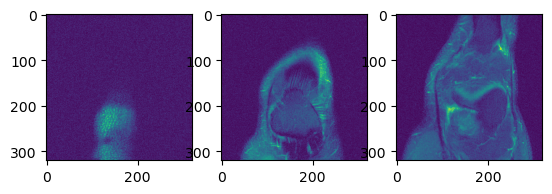

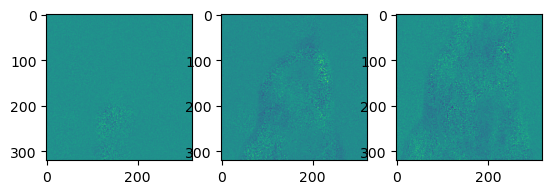

In [13]:
import h5py

hf = h5py.File("/storage/downloads/fastmri_knee/singlecoil_train/file1002518.h5")

volume_kspace = hf['kspace'][()]
reconstruction = hf['reconstruction_esc'][()]
print(volume_kspace.shape)  # dimensions: (number of slices, number of coils, height, width

# middle_index = volume_kspace.shape[0] //2
# slice_kspace = volume_kspace[middle_index] # Choosing the middle slice of this volume

def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

show_coils(np.log(np.abs(volume_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10
# Note that a small constant is added for numerical stability.
show_coils(np.abs(inverse_fft2_shift(volume_kspace)), [0, 5, 10])  # This shows coils 0, 5 and 10
show_coils(reconstruction, [0, 5, 10])  # This shows coils 0, 5 and 10
# show diff between reconstruction and volume_kspace
from data.transforms import complex_center_crop
inverse = inverse_fft2_shift(volume_kspace)
print(inverse.shape)
# Extract real and imaginary parts
real_part = torch.tensor(inverse.real)
imaginary_part = torch.tensor(inverse.imag)

# Stack real and imaginary parts along the last dimension
inverse = torch.stack((real_part, imaginary_part), dim=-1)

cropped = complex_center_crop(inverse, (320, 320))
cropped = torch.view_as_complex(cropped)
show_coils(torch.tensor(reconstruction) - np.abs(cropped), [0, 5, 10])
# print sum of diff
print(torch.sum(torch.abs(torch.tensor(reconstruction) - np.abs(cropped))))


In [ ]:
from data import transforms
resolution = 320
def transform(kspace, target):
        print(kspace.shape)
        print(kspace[100][100])
        kspace = transforms.to_tensor(kspace)
        print(kspace.shape)
        print(kspace[100][100])
        image = transforms.ifft2_regular(kspace)
        print(image.shape)
        image = transforms.complex_center_crop(image, (resolution, resolution))
        print(image.shape)
        
        image, mean, std = transforms.normalize_instance(image, eps=1e-11)
        
        normalized_kspace = transforms.fft2(image)
 
        

        target = transforms.to_tensor(target)
        target, mean, std = transforms.normalize_instance(target, eps=1e-11)

        return normalized_kspace, target


In [ ]:
transform(volume_kspace[0], volume_kspace[0])

(640, 368)
(1.0358266e-05-1.4615733e-05j)
torch.Size([640, 368, 2])
tensor([ 1.0358e-05, -1.4616e-05])
torch.Size([640, 368, 2])
torch.Size([320, 320, 2])


(tensor([[[ 0.0750, -0.0004],
          [-0.0719, -0.0002],
          [ 0.0692,  0.0004],
          ...,
          [-0.0863,  0.0047],
          [ 0.0822, -0.0029],
          [-0.0784,  0.0014]],
 
         [[-0.0414, -0.1019],
          [ 0.0381,  0.1056],
          [-0.0349, -0.1094],
          ...,
          [ 0.0520,  0.0912],
          [-0.0483, -0.0947],
          [ 0.0448,  0.0983]],
 
         [[-0.0934, -0.0218],
          [ 0.0943,  0.0250],
          [-0.0956, -0.0286],
          ...,
          [ 0.0924,  0.0139],
          [-0.0924, -0.0163],
          [ 0.0928,  0.0189]],
 
         ...,
 
         [[-0.0782, -0.0494],
          [ 0.0780,  0.0497],
          [-0.0784, -0.0499],
          ...,
          [ 0.0817,  0.0486],
          [-0.0801, -0.0489],
          [ 0.0789,  0.0491]],
 
         [[ 0.1119, -0.0248],
          [-0.1093,  0.0214],
          [ 0.1067, -0.0183],
          ...,
          [-0.1200,  0.0369],
          [ 0.1172, -0.0325],
          [-0.1145,  0.0285

tensor(64895.0469)


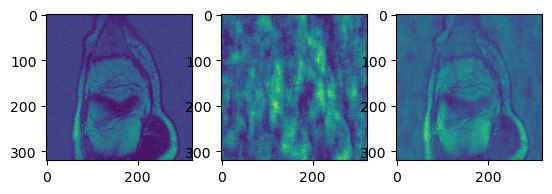

In [ ]:
from models.subsampling import SubsamplingLayer

subsample = SubsamplingLayer(0.8, args.device, args.learn_mask) #initialize subsampling layer - use this in your own model
x, _ = train_loader.dataset[420]
img_orig = freq_to_image(x.unsqueeze(0))
new_x = subsample(x.unsqueeze(0))[0]
fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(img_orig[0])
plt.subplot(1,3,2)
plt.imshow(new_x[0])
plt.subplot(1,3,3)
diff = img_orig[0] - new_x[0]
plt.imshow(diff)
# print if there's any difference
print(torch.sum(diff))


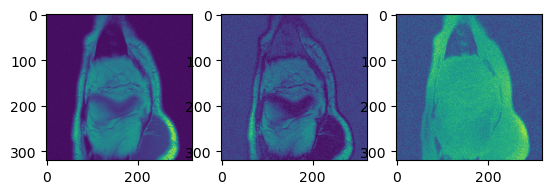

In [ ]:
x, y = train_loader.dataset[420]
complex = torch.view_as_complex(x)
our_img = np.abs(inverse_fft2_shift(complex.numpy()))
# plot y and our_img and diff
fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(y)
plt.subplot(1,3,2)
plt.imshow(our_img)
plt.subplot(1,3,3)
plt.imshow(y - our_img)
